In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
from skimage import exposure
import pickle  # Added pickle import

In [ ]:
# Define the model architecture - must match the saved model
class SkinCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SkinCNN, self).__init__()
        # Initial convolution block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Second convolution block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )
        
        # Third convolution block
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )
        
        # Adaptive pooling to handle variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

In [3]:
# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

try:
    # Try loading the best model first
    model = torch.load("skin_cnn_full_model.pth", map_location=device)
    print("Loaded best model from skin_cnn_full_model.pth")
except FileNotFoundError:
    # Fallback to the regular saved model
    model = torch.load("skincnn.pth", map_location=device)
    print("Loaded model from skincnn.pth")

model.eval()

# Load class names
with open("class_names.pkl", "rb") as f:
    class_names = pickle.load(f)
print("\nAvailable classes:", class_names)

Using device: cuda
Loaded best model from skin_cnn_full_model.pth

Available classes: ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanocytic nevi', 'Melanoma', 'Vascular lesions']


C:\Users\Jatin\AppData\Local\Temp\ipykernel_21252\960570458.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("skin_cnn_full_model.pth", map_location=de

In [4]:
# Function to preprocess and predict
def predict_image(image_path):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    
    # Display original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    # Preprocess image
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Use the same size as training
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        
    # Get top 3 predictions and move to CPU
    top_prob, top_class = torch.topk(probabilities, 3)
    top_prob = top_prob.cpu()
    top_class = top_class.cpu()
    
    # Plot prediction probabilities
    plt.subplot(1, 2, 2)
    plt.barh([class_names[idx] for idx in top_class[0]], top_prob[0])
    plt.title('Top 3 Predictions')
    plt.xlim(0, 1)
    
    # Add percentage labels on bars
    for i, (prob, idx) in enumerate(zip(top_prob[0], top_class[0])):
        plt.text(prob.item(), i, f'{prob.item()*100:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nPrediction Results:")
    print("-" * 50)
    for prob, idx in zip(top_prob[0], top_class[0]):
        print(f"{class_names[idx]}: {prob.item()*100:.2f}% confidence")

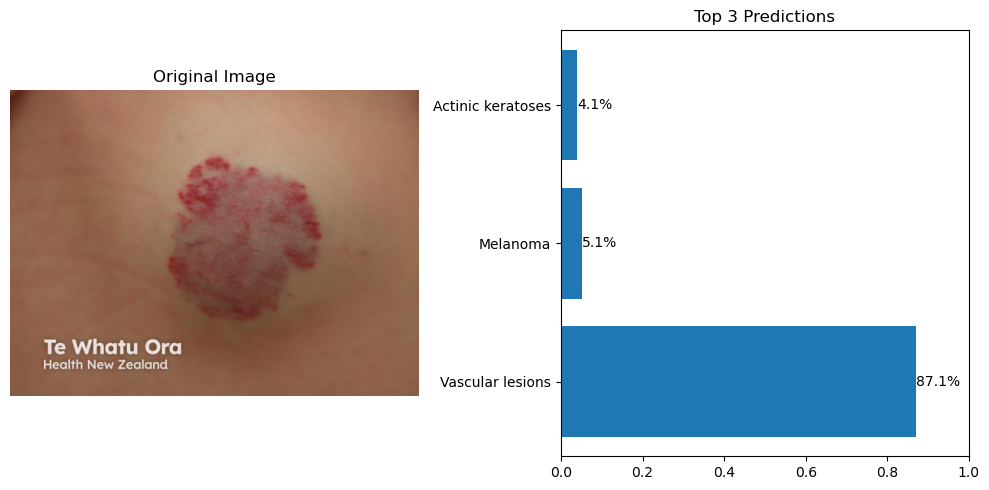


Prediction Results:
--------------------------------------------------
Vascular lesions: 87.11% confidence
Melanoma: 5.15% confidence
Actinic keratoses: 4.06% confidence


In [13]:
# Test the model on ak1.jpg
image_path = "vl2.jpg"
predict_image(image_path)